In [ ]:
import kagglehub
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.metrics import ConfusionMatrix
from sklearn.metrics import confusion_matrix
from wordcloud import WordCloud

importing the dataset

In [ ]:
# Download latest version
path = kagglehub.dataset_download("mannacharya/blinkit-vs-zepto-vs-instamart-reviews")

print("Path to dataset files:", path)

100%|██████████| 561k/561k [00:00<00:00, 40.8MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/mannacharya/blinkit-vs-zepto-vs-instamart-reviews/versions/3


In [ ]:
df = pd.read_csv('/root/.cache/kagglehub/datasets/mannacharya/blinkit-vs-zepto-vs-instamart-reviews/versions/3/reviews.csv')

In [ ]:
df.head()

,rating,date,review,platform
0,2,30 December 2024,"I was using it for long time, but have to stop...",blinkit
1,1,4 November 2024,Loving the fast deliveries and mostly they are...,blinkit
2,1,31 October 2024,The customer support is very disappointing. I ...,blinkit
3,5,29 August 2024,"I've been using Blinkit for a while now, and i...",blinkit
4,2,31 December 2024,Blinkit was my go to app and it was rare that ...,blinkit


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4620 entries, 0 to 4619
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   rating    4620 non-null   int64 
 1   date      4620 non-null   object
 2   review    4620 non-null   object
 3   platform  4620 non-null   object
dtypes: int64(1), object(3)
memory usage: 144.5+ KB


In [ ]:
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4620 entries, 0 to 4619
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   rating    4620 non-null   int64         
 1   date      4620 non-null   datetime64[ns]
 2   review    4620 non-null   object        
 3   platform  4620 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 144.5+ KB


In [ ]:
df.isnull().sum()

,0
rating,0
date,0
review,0
platform,0


In [ ]:
#check duplicates
df.duplicated().sum()

np.int64(0)

In [ ]:
# cleaning the review column
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_review(review):
    # Remove non-alphabetic characters and convert to lowercase
    review = review.lower()
    review = re.sub(r'[^a-zA-Z]', ' ', review)

    #remove stopwords
    words = review.split()
    words = [word for word in words if word not in stop_words]

    #lemmatization
    words = [lemmatizer.lemmatize(word) for word in words]

    #join words back into one string
    return ' '.join(words)

df['review'] = df['review'].apply(clean_review)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df.head(5)

,rating,date,review,platform
0,2,2024-12-30,using long time stop using recently got used i...,blinkit
1,1,2024-11-04,loving fast delivery mostly great quick delive...,blinkit
2,1,2024-10-31,customer support disappointing recently bought...,blinkit
3,5,2024-08-29,using blinkit become go app grocery shopping a...,blinkit
4,2,2024-12-31,blinkit go app rare disappointed today disappo...,blinkit


**EDA**

In [ ]:
df.describe()

,rating,date
count,4620.000000,4620
mean,1.827273,2024-10-12 07:19:28.831168768
min,1.000000,2020-07-21 00:00:00
25%,1.000000,2024-10-25 00:00:00
50%,1.000000,2024-11-27 00:00:00
75%,2.000000,2024-12-18 00:00:00
max,5.000000,2024-12-31 00:00:00
std,1.461208,NaN


the 75% quratal is of negative review. and mean is 1.82, standard deviation is 1.46 which is not great for delevery app rating

In [ ]:
#count of rating based on platform
rating_count = df.groupby(['rating','platform']).size().reset_index(name='count')

In [ ]:
rating_count

,rating,platform,count
0,1,blinkit,713
1,1,jiomart,1216
2,1,zepto,1376
3,2,blinkit,83
4,2,jiomart,79
5,2,zepto,117
6,3,blinkit,78
7,3,jiomart,47
8,3,zepto,63
9,4,blinkit,120


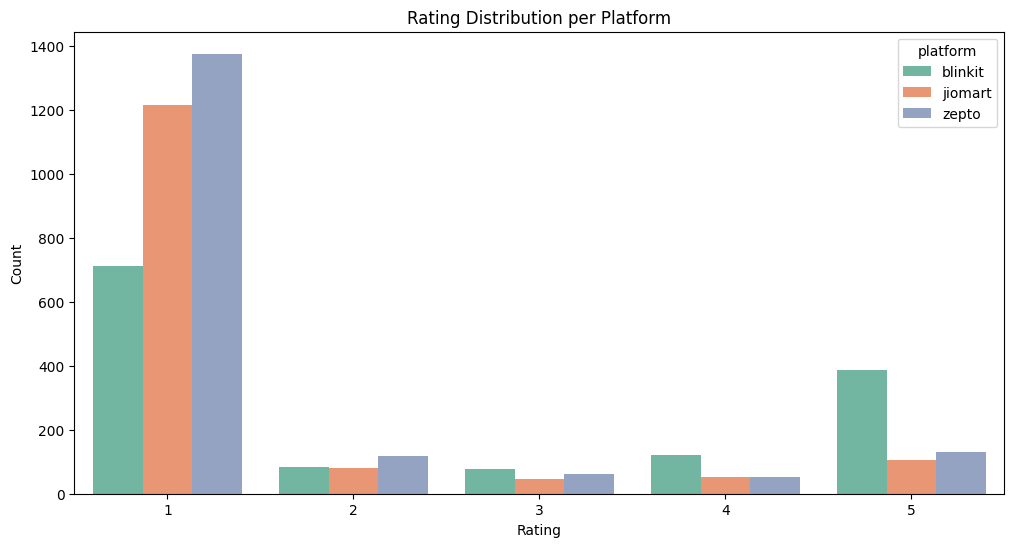

In [ ]:
# Plot rating counts per platform
plt.figure(figsize=(12, 6))
sns.countplot(x='rating', hue='platform', data=df, palette='Set2')
plt.title('Rating Distribution per Platform')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

from above chart, we can see the all plotform has received most number of negative review

In [ ]:
# volume of review over time by month
month_reviews = df.groupby([df['platform'],df['date'].dt.to_period('M')]).size().reset_index(name='review_count')
month_reviews.head()


,platform,date,review_count
0,blinkit,2024-07,1
1,blinkit,2024-08,6
2,blinkit,2024-09,5
3,blinkit,2024-10,351
4,blinkit,2024-11,329


In [ ]:
#convert the period back to datetime for plotting
month_reviews['date'] = month_reviews['date'].dt.to_timestamp()
month_reviews.head()

,platform,date,review_count
0,blinkit,2024-07-01,1
1,blinkit,2024-08-01,6
2,blinkit,2024-09-01,5
3,blinkit,2024-10-01,351
4,blinkit,2024-11-01,329


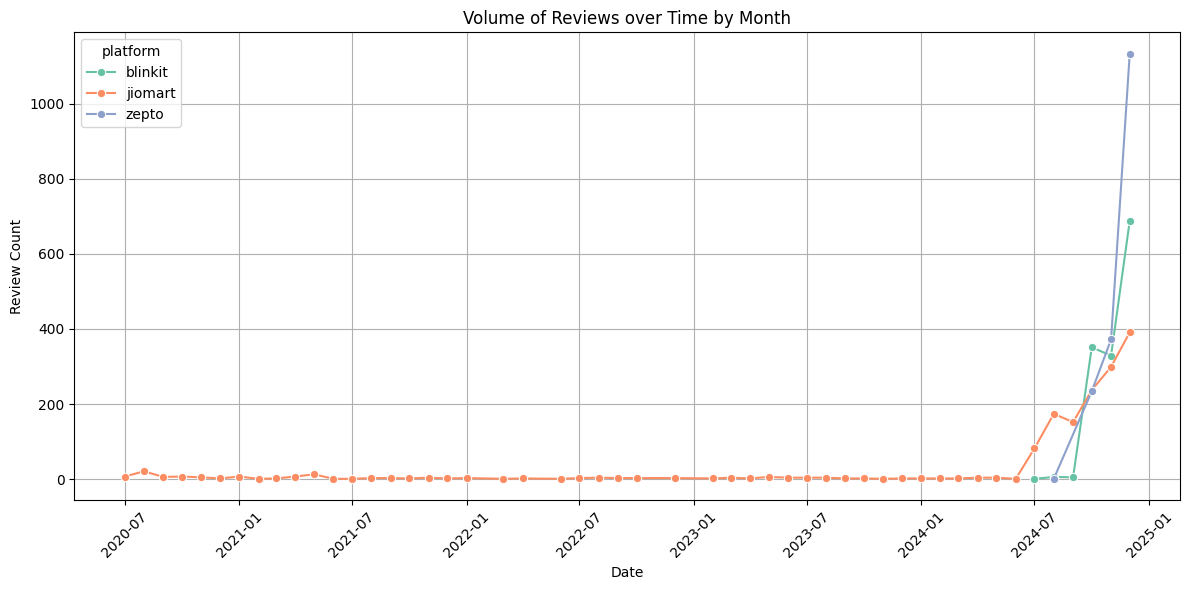

In [ ]:
#plotting seaborn
plt.figure(figsize=(12,6))
sns.lineplot(x='date', y='review_count', hue='platform', data=month_reviews, palette='Set2',marker = 'o')
plt.title('Volume of Reviews over Time by Month')
plt.xlabel('Date')
plt.ylabel('Review Count')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

From above line chart, we can see most number of review are started from **june 2024**. we can assume all the platform penetrate in most number devices in urban india and from negative review we assume the companies are not able to cater the public demand.
# Example zepto has recievd most number of review and reviews are exploided after june 2024 but it has negative reviews.

In [ ]:
#Cheking rating and review sentiment align!
#First we will convert review into sentiment score into ['positive','negative','neutral']
# vader analysis
#analysis of review column
# if reviews are bad then the vader will give negative, vice versa for positive and negative
#vadder assigns a sentiment score between -1 (most negative) and +1 (most positive), with 0 indicating neutral sentiment.

In [ ]:
nltk.download('vader_lexicon')

def get_sentiment_score(review):
    sid = SentimentIntensityAnalyzer()
    sentiment_score = sid.polarity_scores(review)['compound']

    if(sentiment_score >= 0.05):
        return 'positive'
    elif(sentiment_score <= -0.05):
        return 'negative'
    else:
        return 'neutral'

df['sentiment_score'] = df['review'].apply(get_sentiment_score)

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


In [ ]:
df.head()

,rating,date,review,platform,sentiment_score
0,2,2024-12-30,using long time stop using recently got used i...,blinkit,positive
1,1,2024-11-04,loving fast delivery mostly great quick delive...,blinkit,positive
2,1,2024-10-31,customer support disappointing recently bought...,blinkit,positive
3,5,2024-08-29,using blinkit become go app grocery shopping a...,blinkit,positive
4,2,2024-12-31,blinkit go app rare disappointed today disappo...,blinkit,negative


In [ ]:
#now we will convert rating into sentimental score - ['positive','negative','neutral']
def rating_to_sentiment(rating):
    if rating >= 4:
        return 'positive'
    elif rating <= 2:
        return 'negative'
    else:
        return 'neutral'

df['rating_sentiment'] = df['rating'].apply(rating_to_sentiment)

In [ ]:
df.head()

,rating,date,review,platform,sentiment_score,rating_sentiment
0,2,2024-12-30,using long time stop using recently got used i...,blinkit,positive,negative
1,1,2024-11-04,loving fast delivery mostly great quick delive...,blinkit,positive,negative
2,1,2024-10-31,customer support disappointing recently bought...,blinkit,positive,negative
3,5,2024-08-29,using blinkit become go app grocery shopping a...,blinkit,positive,positive
4,2,2024-12-31,blinkit go app rare disappointed today disappo...,blinkit,negative,negative


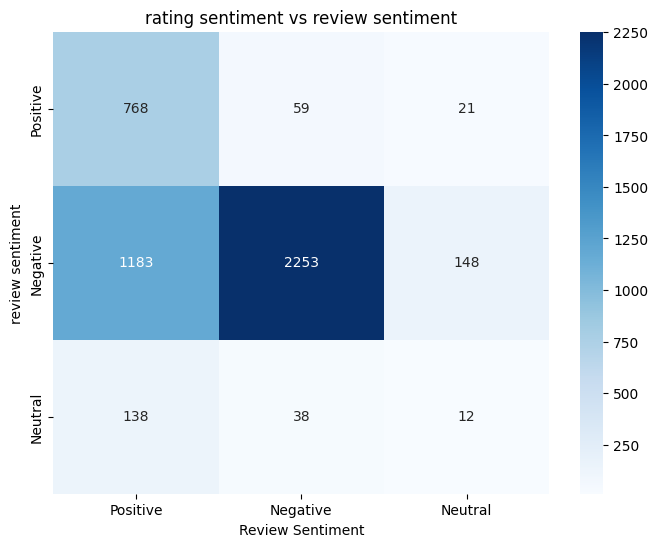

In [ ]:
#comparing the rating sentiment vs review sentiment
conf_mat = confusion_matrix(df['rating_sentiment'], df['sentiment_score'], labels=['positive', 'negative', 'neutral'])

plt.figure(figsize=(8, 6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=['Positive', 'Negative', 'Neutral'], yticklabels=['Positive', 'Negative', 'Neutral'])
plt.xlabel('Review Sentiment')
plt.ylabel('review sentiment')
plt.title('rating sentiment vs review sentiment')
plt.show()

From above **confusion matrix**, even though user gave positive rating but with negative review.

This type rating maybe comes from Loyal User, hesitate to give low rating or its sarcasm

In [ ]:
#alignment percentage
matches = (df['rating_sentiment'] == df['sentiment_score']).sum()
total = len(df)
accuracy = matches / total
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 65.65%


**Visualization**

<ipython-input-33-fb1b4577178d>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Set2')


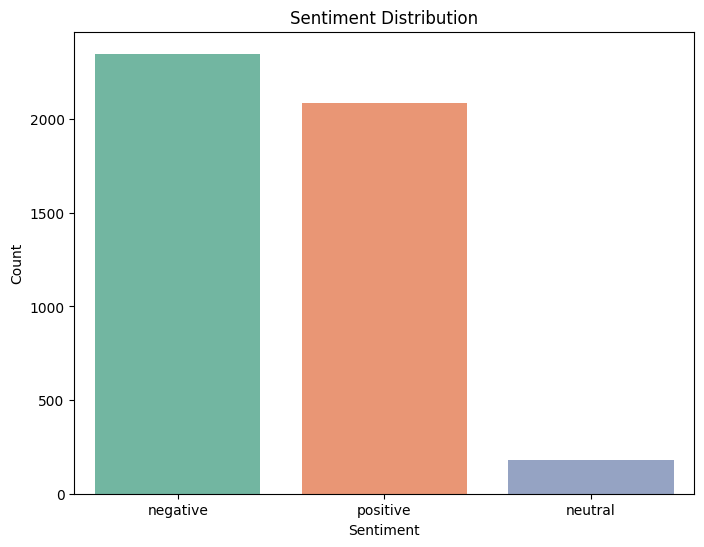

In [ ]:
# sentimental distribution
sentiment_counts = df['sentiment_score'].value_counts()

plt.figure(figsize=(8, 6))
sns.barplot(x=sentiment_counts.index, y=sentiment_counts.values, palette='Set2')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

all the platform majoritily recieved negative review.

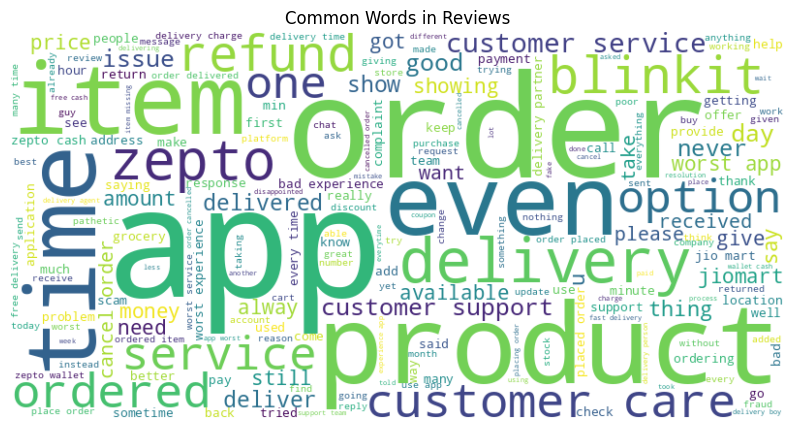

In [ ]:
#common words in review
all_reviews = ' '.join(df['review']) #combine all words in one sentence
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(all_reviews)

plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Common Words in Reviews')
plt.show()


most negative reviews are about delivery, time, experince, service, refund, delivery charges, cancelled order and product.

Conclusion:
The delevery platform should focus on user experince, service to the user, delivery charges should cut down if necessary.
Add new stores to residential populated areas. product quality must ensure. training to delivery boy if required.

# **READ.ME**
# Sentiment Analysis of Delivery Apps (Blinkit, Zepto, Jiomart)

This project performs sentiment analysis on customer reviews of three popular delivery apps in India: Blinkit, Zepto, and Jiomart. The analysis aims to understand customer satisfaction, identify key areas for improvement, and compare the performance of these platforms.

## Project Structure

*   **reviews.csv:** The dataset containing customer reviews.
*   **Sentiment_Analysis_Delivery_Apps.ipynb:** The Jupyter notebook containing the code for data loading, preprocessing, sentiment analysis, and visualization.
*   **README.md:** This file providing an overview of the project.

## Data Source

The dataset used for this analysis is sourced from Kaggle: [Blinkit vs Zepto vs Jiomart Reviews]. It includes customer reviews, ratings, and platform information.

## Methodology

1.  **Data Loading and Preprocessing:** The dataset is loaded using Pandas, and the review text is cleaned by removing stop words, punctuation, and performing lemmatization.
2.  **Sentiment Analysis:** Sentiment scores are calculated for each review using VADER (Valence Aware Dictionary and sEntiment Reasoner). Reviews are categorized as positive, negative, or neutral based on their sentiment scores.
3.  **Visualization:** The results are visualized using various plots, including bar charts, line charts, and word clouds.

## Key Findings

*   **Overall Sentiment:** The majority of reviews across all platforms are negative, indicating a need for improvement in customer satisfaction.
*   **Rating vs. Sentiment Alignment:** There is a significant mismatch between customer ratings and the sentiment expressed in their reviews. Many users provide positive ratings despite writing negative reviews.
*   **Common Themes:** Common negative themes in reviews include delivery issues, service quality, pricing, and product availability.
*   **Platform Comparison:** Zepto receives the highest volume of reviews, but it also has a high proportion of negative reviews. Blinkit and Instamart have relatively fewer reviews but comparable sentiment distributions.

## Conclusion

This analysis reveals valuable insights into customer sentiment towards Blinkit, Zepto, and Jiomart. The delivery platforms should focus on addressing the key concerns highlighted in the negative reviews to enhance customer satisfaction and loyalty.

## Future Work

*   Fine-tune the sentiment analysis model for improved accuracy.
*   Explore topic modeling to identify specific areas of improvement for each platform.
*   Analyze the impact of customer demographics on sentiment.
*   Develop a real-time sentiment monitoring system for continuous feedback analysis.